In [1]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import to_pil_image
from datetime import datetime
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as T
import numpy as np
import random
import torch.nn as nn
import os
from PIL import Image
from tqdm import tqdm
import torch

In [2]:
def pad_to_multiple_of(x, multiple=32):
    # x: tensor (C,H,W)
    _, H, W = x.shape
    pad_h = (multiple - H % multiple) % multiple
    pad_w = (multiple - W % multiple) % multiple
    return F.pad(x, (0, pad_w, 0, pad_h), mode="constant", value=0)

In [3]:
class CopyMoveSegmentationDataset(Dataset):
    def __init__(self, forged_paths, authentic_paths, mask_paths, train=True, test_split=0.2, seed=42):
        self.image_paths = []
        self.mask_paths = []

        # Load forged images
        for filename in os.listdir(forged_paths):
            self.image_paths.append(forged_paths + filename)
            self.mask_paths.append(mask_paths + filename.split('.')[0] + '.npy')

        # Load authentic images
        for filename in os.listdir(authentic_paths):
            self.image_paths.append(authentic_paths + filename)
            self.mask_paths.append("real")

        # Create a train/test split
        total_size = len(self.image_paths)
        test_size = int(total_size * test_split)
        train_size = total_size - test_size
        random.seed(seed)
        indices = list(range(total_size))
        random.shuffle(indices)

        if train:
            selected_indices = indices[:train_size]
        else:
            selected_indices = indices[train_size:]

        self.image_paths = [self.image_paths[i] for i in selected_indices]
        self.mask_paths = [self.mask_paths[i] for i in selected_indices]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = np.array(Image.open(self.image_paths[idx]).convert("RGB")) / 255.
        if self.mask_paths[idx] == "real":
            mask = np.zeros((1, image.shape[0], image.shape[1]))
        else:
            mask = np.expand_dims(np.max(np.load(self.mask_paths[idx]), axis=0), axis=0)  # shape (H, W)

        # Convert to torch tensors
        image = torch.tensor(image).permute(2, 0, 1).float()
        mask = torch.tensor(mask).float()

        # Pad to multiple
        image = pad_to_multiple_of(image)
        mask = pad_to_multiple_of(mask)

        # Apply data augmentation (random rotation, flip, translation)
        # image, mask = self.augment(image, mask)

        return image, mask

    def augment(self, image, mask):
        return image, mask
        # Random horizontal flip
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # Random vertical flip
        if random.random() > 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)

        # Random 90-degree rotation
        k = random.randint(0, 3)  # 0, 1, 2, 3
        if k > 0:
            image = torch.rot90(image, k, [1, 2])
            mask = torch.rot90(mask, k, [1, 2])

        # Optional: small translation
        max_dx = 10
        max_dy = 10
        translations = (random.randint(-max_dx, max_dx), random.randint(-max_dy, max_dy))
        image = TF.affine(image, angle=0, translate=translations, scale=1, shear=0)
        mask = TF.affine(mask, angle=0, translate=translations, scale=1, shear=0)

        return image, mask

    def get_train_set(self):
        # Return a new dataset instance that is the training set
        return CopyMoveSegmentationDataset(
            forged_paths="",  # Paths are already embedded, so you might need to refactor
            authentic_paths="",
            mask_paths="",
            transform=self.transform,
            train=True
        )

In [4]:
from torchvision.models import resnet18, ResNet18_Weights

# ----------------------------------------------------
# Decoder block (standard U-Net style but lightweight)
# ----------------------------------------------------
class DecoderBlock(nn.Module):
    def __init__(self, in_c, skip_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, 2, stride=2)

        self.conv = nn.Sequential(
            nn.Conv2d(out_c + skip_c, out_c, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_c, out_c, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
        )

    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)


# ----------------------------------------------------
# Pretrained ResNet18 U-Net
# ----------------------------------------------------
class ResNetUNet(nn.Module):
    def __init__(self, n_classes=1):
        super().__init__()

        # Load pretrained ResNet18
        backbone = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

        # Encoder layers
        self.inc = nn.Sequential(
            backbone.conv1,
            backbone.bn1,
            backbone.relu
        )  # 64 channels, H/2

        self.maxpool = backbone.maxpool            # H/4

        self.enc1 = backbone.layer1                # 64 channels
        self.enc2 = backbone.layer2                # 128 channels
        self.enc3 = backbone.layer3                # 256 channels
        self.enc4 = backbone.layer4                # 512 channels  (bottleneck input)

        # Decoder
        self.dec4 = DecoderBlock(512, 256, 256)
        self.dec3 = DecoderBlock(256, 128, 128)
        self.dec2 = DecoderBlock(128, 64, 64)
        self.dec1 = DecoderBlock(64, 64, 32)

        self.final_up = nn.ConvTranspose2d(32, 16, 2, stride=2)

        self.final = nn.Conv2d(16, n_classes, kernel_size=1)

    def forward(self, x):
        # ----- Encoder -----
        x0 = self.inc(x)              # 64     H/2
        x1 = self.maxpool(x0)         # 64     H/4
        x1 = self.enc1(x1)            # 64

        x2 = self.enc2(x1)            # 128    H/8
        x3 = self.enc3(x2)            # 256    H/16
        x4 = self.enc4(x3)            # 512    H/32

        # ----- Decoder -----
        d4 = self.dec4(x4, x3)        # 256
        d3 = self.dec3(d4, x2)        # 128
        d2 = self.dec2(d3, x1)        # 64
        d1 = self.dec1(d2, x0)        # 32

        out = self.final_up(d1)
        out = self.final(out)

        return out

In [5]:
bce = nn.BCEWithLogitsLoss()
scaler = torch.cuda.amp.GradScaler()

def train_unet_fast(model, train_loader, optimizer, epochs=20,
               device="cuda"):

    model = model.to(device)

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0

        print(f"Epoch {epoch+1}/{epochs}: {datetime.now()}")

        for img, mask in train_loader:

            img = img.to(device)          # (1, 3, H, W)
            mask = mask.to(device)        # (1, 1, H, W)

            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                pred = model(img)
                loss = criterion(pred, mask)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            epoch_loss += loss.item()

        print(f"Epoch {epoch+1} Loss: {epoch_loss / len(train_loader):.4f}")

        if (epoch + 1) % 5 == 0:
            torch.save(model.state_dict(), f"unet_epoch_{epoch+1}.pth")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

ds = CopyMoveSegmentationDataset(
    forged_paths="data/train_images/forged/",
    authentic_paths="data/train_images/authentic/",
    mask_paths="data/train_masks/"
)

train_loader = DataLoader(ds, batch_size=1, shuffle=True, num_workers=4,
                          pin_memory=True)

model = ResNetUNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCELoss()

# train_unet_fast(model, train_loader, optimizer, device=device, epochs=1000)

Using device: cpu


C:\Users\sseif\AppData\Local\Temp\ipykernel_12572\395224799.py:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
C:\Users\sseif\AppData\Roaming\Python\Python312\site-packages\torch\cuda\amp\grad_scaler.py:31: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  super().__init__(


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = ResNetUNet(n_classes=1)
model.load_state_dict(torch.load("unet_epoch_10.pth", map_location=device))
model.to(device)
model.eval()

test_ds = CopyMoveSegmentationDataset(
    forged_paths="data/train_images/forged/",
    authentic_paths="data/train_images/authentic/",
    mask_paths="data/train_masks/",
    train=False
)

test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

def predict_mask(model, image_tensor):
    with torch.no_grad():
        logits = model(image_tensor.unsqueeze(0))
        pred = torch.sigmoid(logits)
        pred = pred.squeeze(0).squeeze(0).cpu().numpy()
    return pred

def show_results(img, true_mask, pred_mask, threshold=0.5):
    pred_binary = (pred_mask > threshold).astype(np.float32)

    fig, axs = plt.subplots(1, 3, figsize=(15,5))

    axs[0].imshow(np.transpose(img.numpy(), (1,2,0)))
    axs[0].set_title("Image")
    axs[0].axis("off")

    axs[1].imshow(true_mask.squeeze(), cmap='gray')
    axs[1].set_title("True Mask")
    axs[1].axis("off")

    axs[2].imshow(pred_binary, cmap='gray')
    axs[2].set_title("Predicted Mask")
    axs[2].axis("off")

    plt.show()

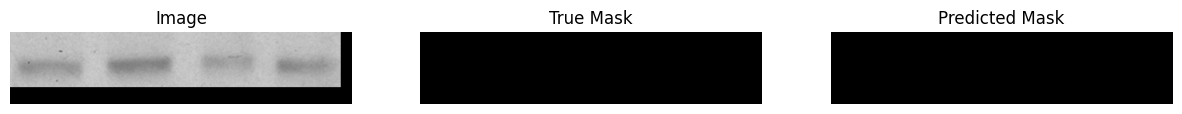

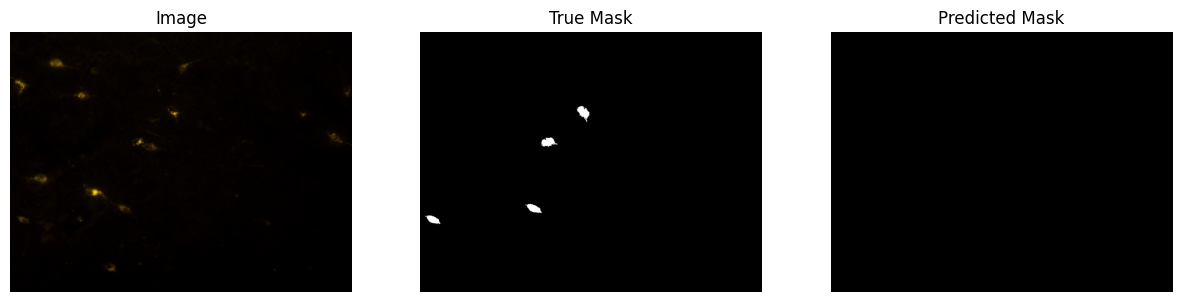

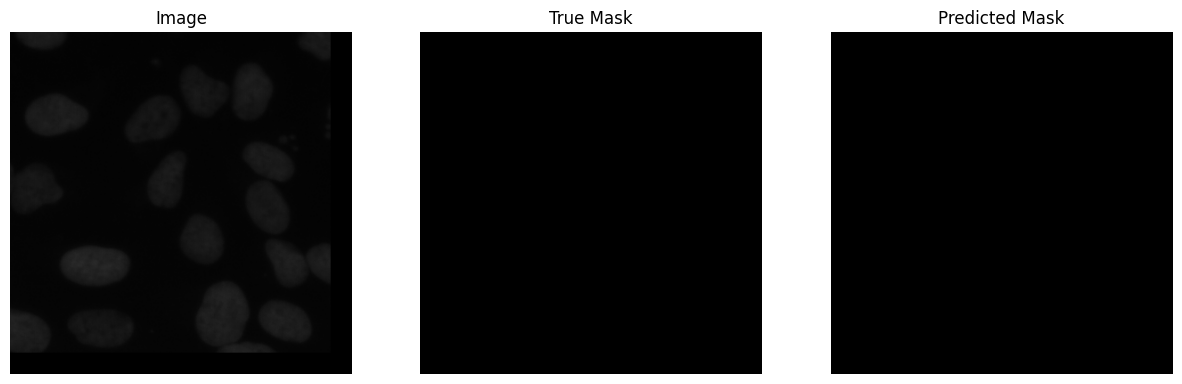

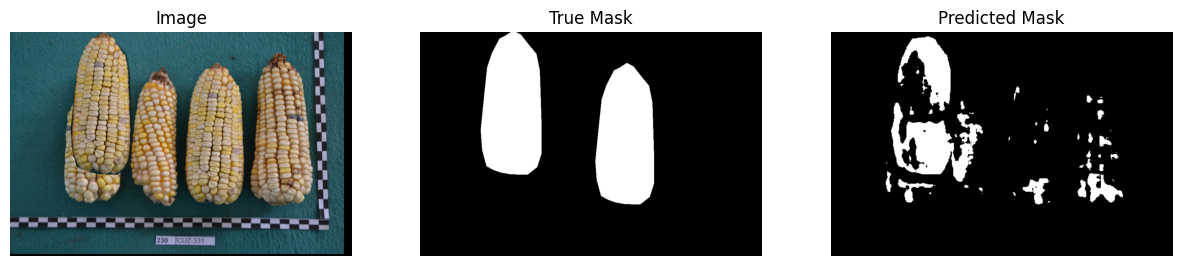

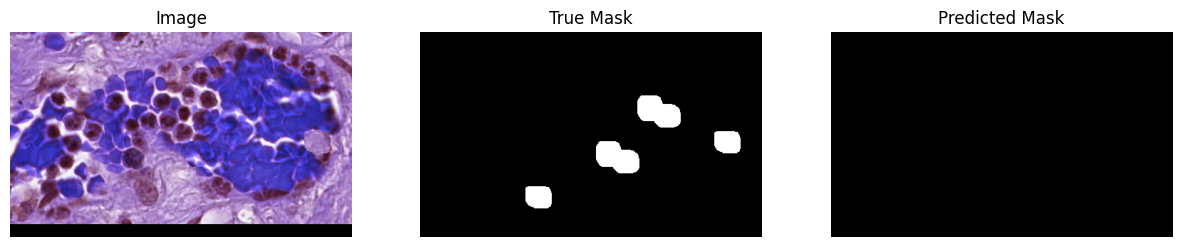

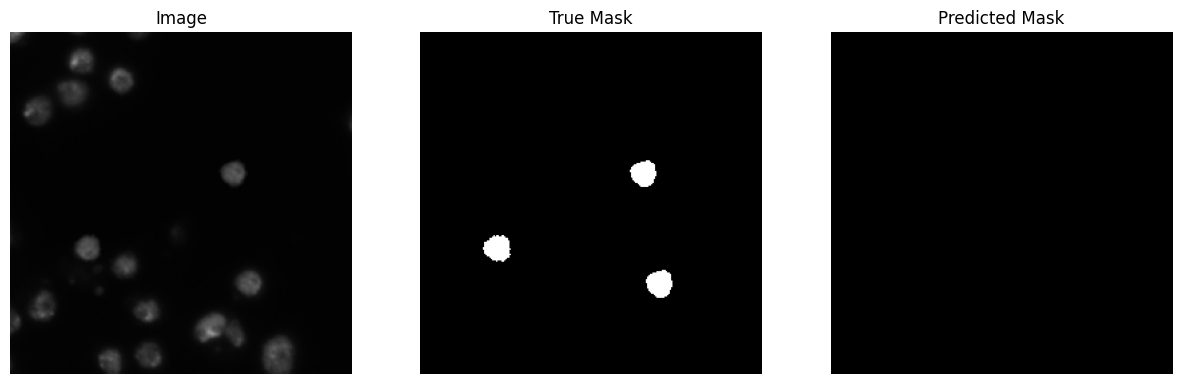

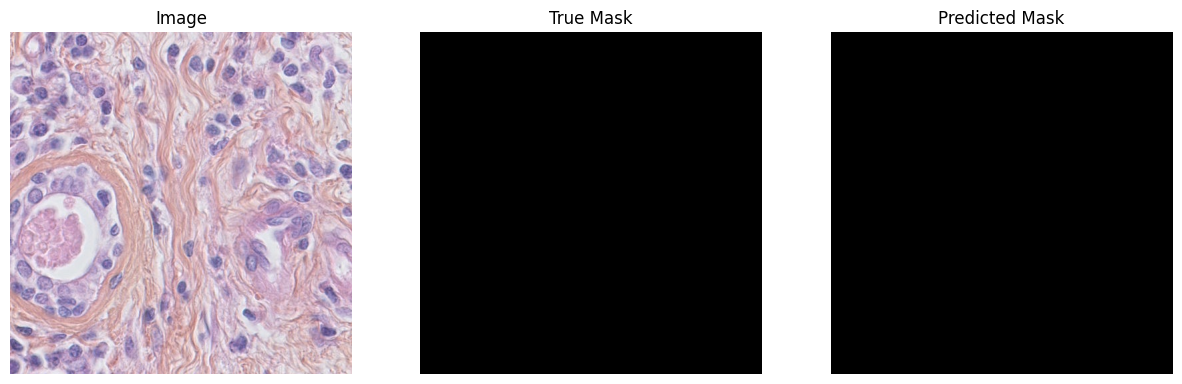

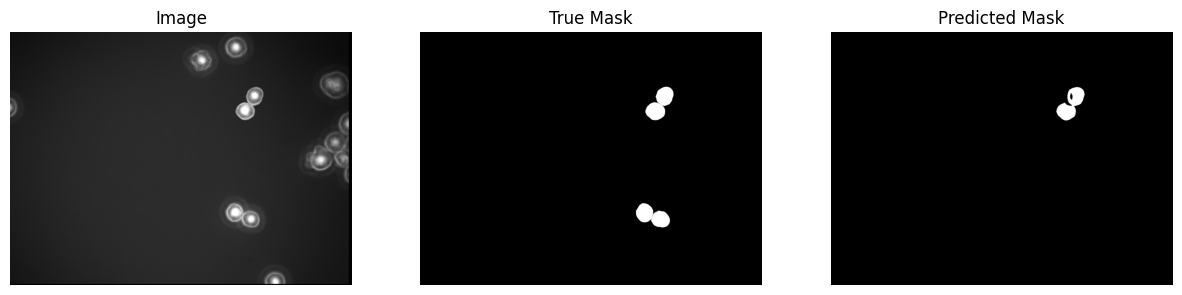

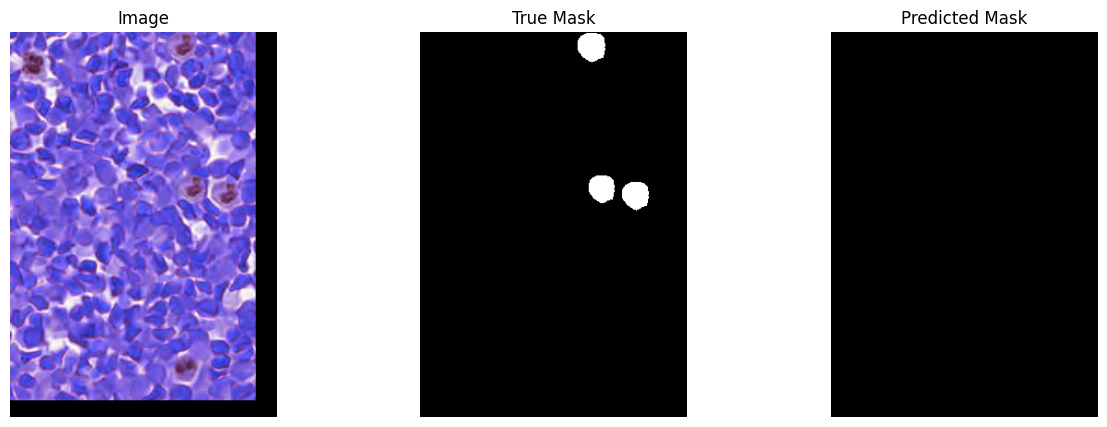

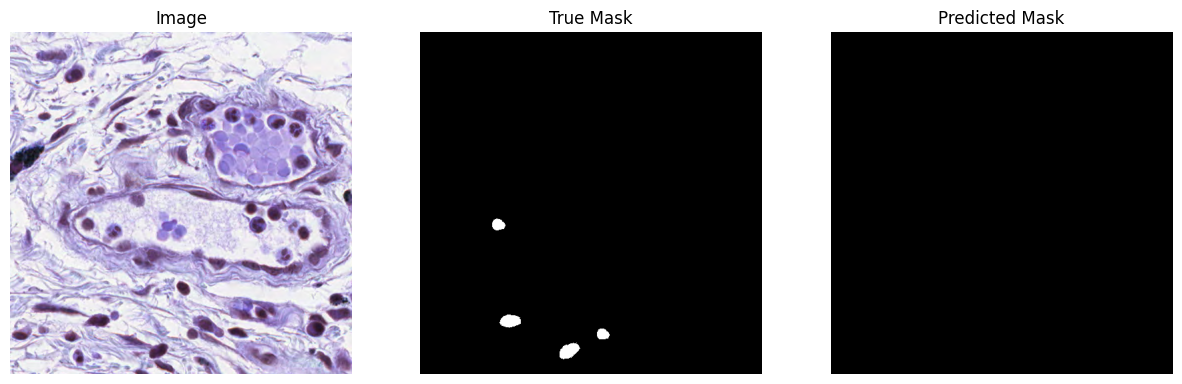

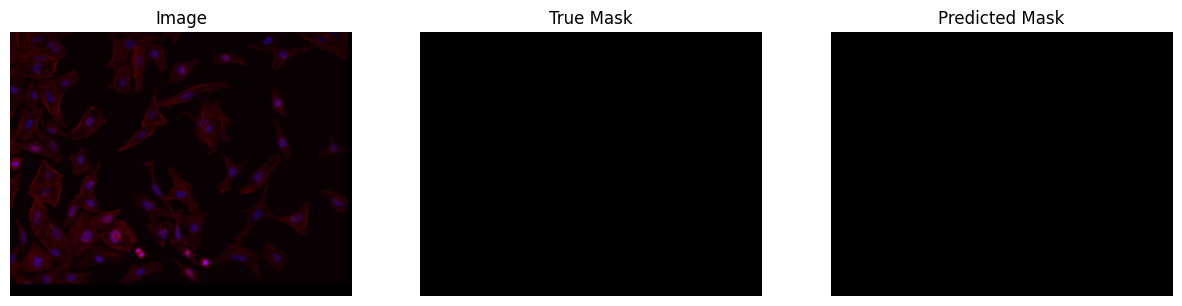

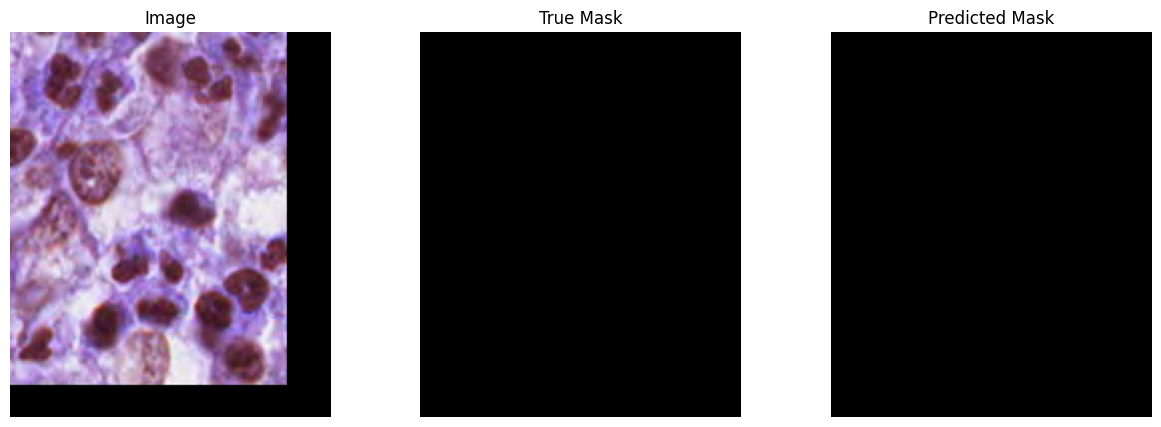

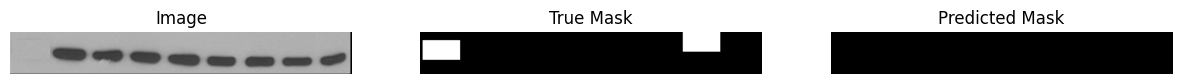

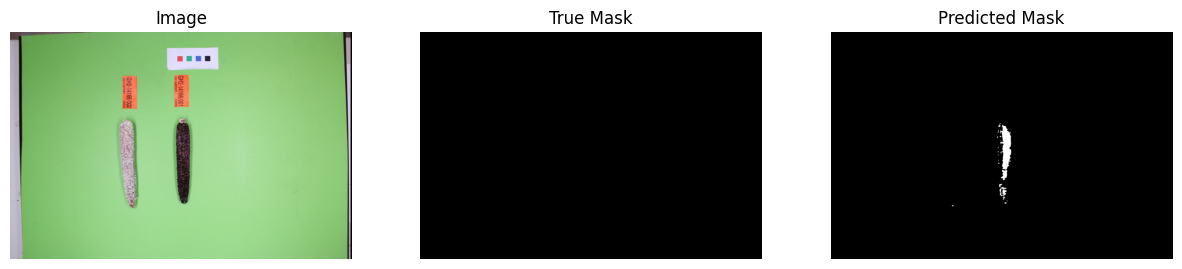

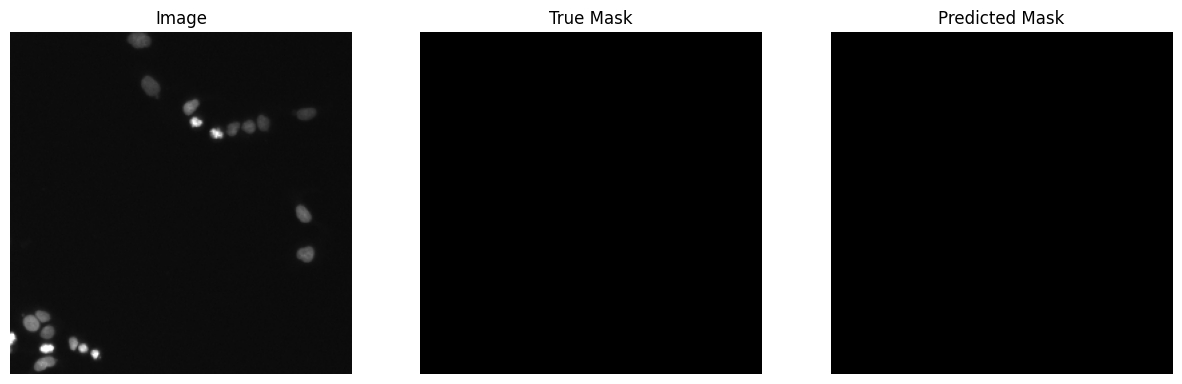

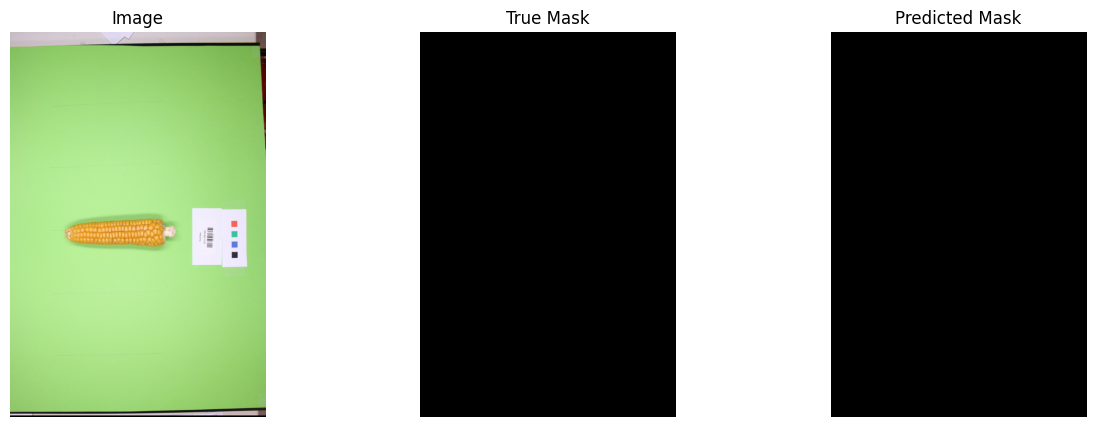

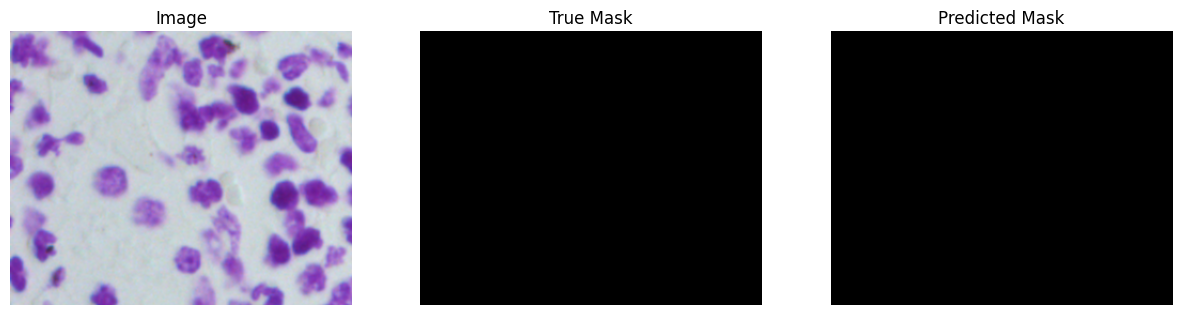

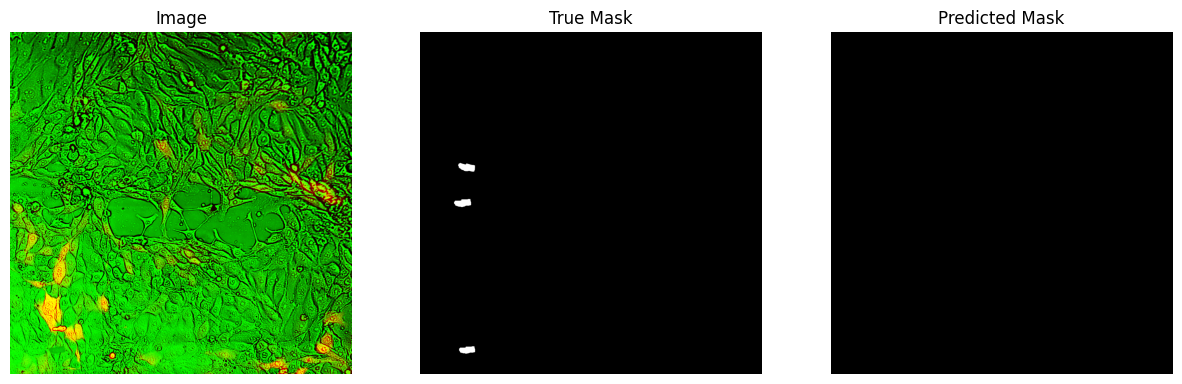

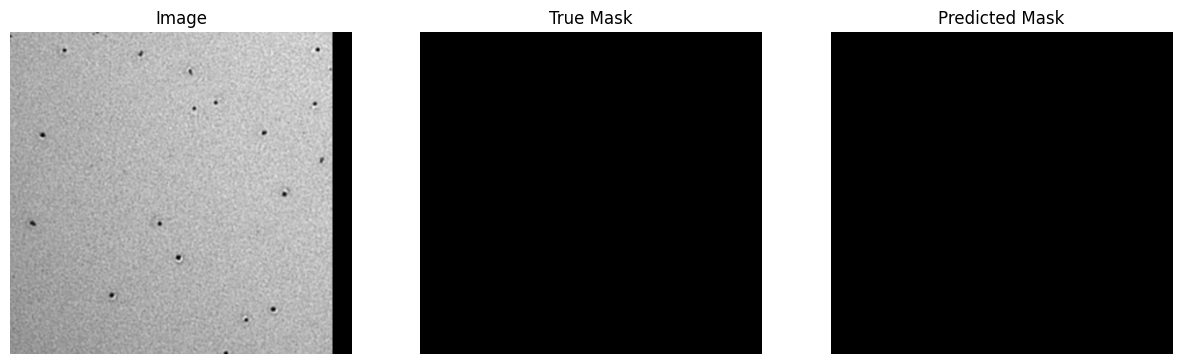

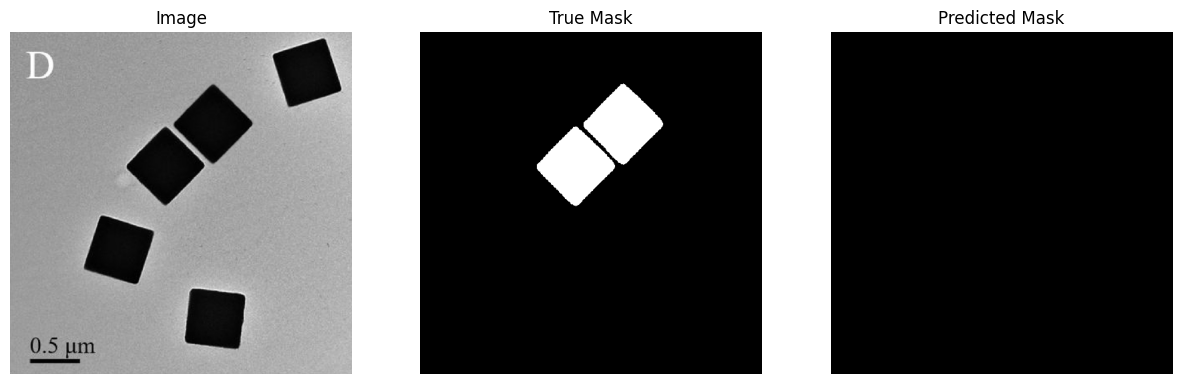

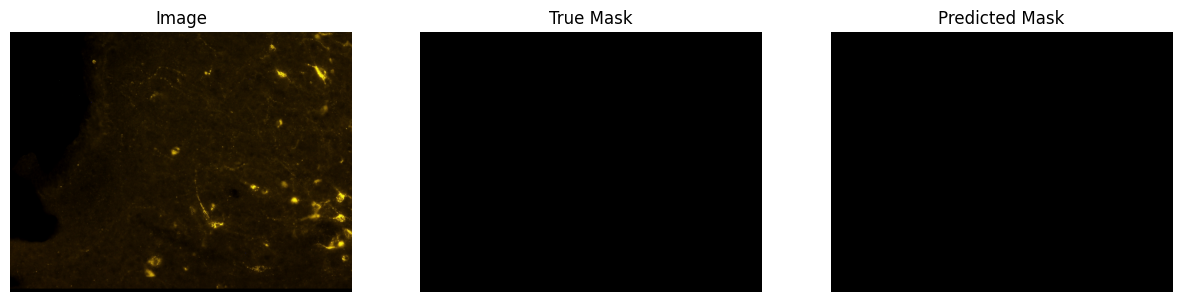

In [7]:
for i, (img, mask) in enumerate(test_loader):
    img = img.to(device)
    mask = mask.cpu()

    pred = predict_mask(model, img[0].to(device))

    show_results(img[0].cpu(), mask[0], pred)

    if i == 20:   # ONLY show the first 20 images, adjust as needed
        break

In [8]:
class CopyMoveClassificationDataset(Dataset):
    def __init__(self, forged_paths, authentic_paths, train=True, test_split=0.2, seed=42, img_size=128, unet="unet_epoch_10.pth"):
        
        self.size = img_size
        self.image_paths = []
        self.classification = []

        # Load forged images
        for filename in os.listdir(forged_paths):
            self.image_paths.append(forged_paths + filename)
            self.classification.append(1)

        # Load authentic images
        for filename in os.listdir(authentic_paths):
            self.image_paths.append(authentic_paths + filename)
            self.classification.append(0)
                
        self.model = ResNetUNet(n_classes=1)
        self.model.load_state_dict(torch.load(unet, map_location=device))
        self.model.to(device)
        self.model.eval()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = np.array(Image.open(self.image_paths[idx]).convert("RGB")) / 255

        # Convert to torch tensors
        image = torch.tensor(image).permute(2, 0, 1).float()
        image = pad_to_multiple_of(image)
        
        with torch.no_grad():
            logits = self.model(image.unsqueeze(0))
            #print(logits.shape, image.shape)
            image = torch.sigmoid(logits)
        
        image = F.interpolate(image, size=(self.size, self.size), mode="nearest").squeeze(0)
        #print(image.shape)
        
        return image, self.classification[idx]

In [9]:
class ClassifierCNN(nn.Module):
    """
    Baseline CNN classifier.
    """
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),       # 64x64

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),       # 32x32

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),       # 16x16
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 128),
            nn.ReLU(),
            nn.Linear(128, 2),      # authentic vs forged
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [10]:
def train_classifier():

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    ds = CopyMoveClassificationDataset(
        authentic_paths="data/train_images/authentic/",
        forged_paths="data/train_images/forged/",
        img_size=128
    )

    loader = DataLoader(ds, batch_size=32, shuffle=True, num_workers=0)

    model = ClassifierCNN().to(device)
    opt = torch.optim.Adam(model.parameters(), lr=0.1)
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(10):
        model.train()
        total_loss = 0
        correct = 0

        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            print("here")

            logits = model(imgs)
            loss = loss_fn(logits, labels)

            opt.zero_grad()
            loss.backward()
            opt.step()

            total_loss += loss.item()
            correct += (logits.argmax(dim=1) == labels).sum().item()

        acc = correct / len(ds)
        print(f"Epoch {epoch+1} | loss={total_loss/len(loader):.4f} | acc={acc:.3f}")

    torch.save(model.state_dict(), "baseline_classifier.pth")
    print("Saved baseline classifier.")

In [ ]:
train_classifier()

Using device: cpu
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
Epoch 1 | loss=96.7443 | acc=0.529
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
he